
# Bayesian networks for risk prediction when granting credits



## Libraries import


In [1]:
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models.BayesianModel import BayesianModel
import networkx as nx
import pylab as plt
import pandas as pd
import numpy as np


In [2]:
# The dataset is loaded excluding the first indexed column

data = pd.read_csv("Riesgo_Credito.csv", usecols=range(1, 11))
data.head()


,Evaluacion crediticia historica,Edad,Genero,Evaluacion Sueldo,Residencia,Nivel de ahorro,Monto del credito,Duracion,Proposito,Riesgo
0,4,38 to 75,male,2,own,no account,250 to 1554,4 to 12,radio/TV,good
1,2,19 to 28,female,2,own,little,250 to 1554,12 to 24,radio/TV,bad
2,4,28 to 38,male,1,own,little,250 to 1554,4 to 12,education,good
3,2,28 to 38,male,2,free,little,1554 to 3368,12 to 24,furniture/equipment,good
4,3,28 to 38,male,2,free,little,250 to 1554,4 to 12,car,bad



## 1.1 Hill-Climbing network structure learning method



On many occasions we do not have the expert knowledge of the interrelationships and dependencies between a certain set of variables that represent a specific context, however, there is data that describes different possible states of a system, through these data we can learn a structure Bayesian network appropriate to the system. Here is one of the most used methods:

 **Learning of Hill-Climbing network structures:** Hill-Climbing is a local search algorithm that seeks to maximize an objective function by modifying the current state of a solution or moving through different previously generated solutions. In structure learning, the objective function is a **Score** of how well a certain Bayesian network structure fits a dataset. The most used scores are: Akaike&#39;s information criterion ( **AIC** ), Bayesian information criterion ( **BIC** ) and Bayesian Dirichlet equivalence score ( **BDe** ). Once the Hill-Climbing optimization criterion is selected, it explores and exploits the different possible solutions seeking to maximize the score, the movement through the solutions can be done by changing adding edges between two variables, eliminating edges, changing the direction of edges, etc. With this method it is not guaranteed to find the global optimum, however, it is a realistic approach, since, the problem of finding the optimal structure is **NP-HARD** , the time needed to solve the problem grows exponentially.



## 1.2 BICScore Method and Network Structure


In [3]:
# We load the BICscore scoring method
score_method = BicScore(data=data)
# We fit the Hill-Climbing algorithm to our data and define the type of score to use
hc = HillClimbSearch(data=data, scoring_method=score_method)
# We estimate the appropriate network structure for the data (Hill-Climbing does not ensure finding the optimal structure)
model = hc.estimate()


  0%|                                                                          | 12/1000000 [00:02<52:55:52,  5.25it/s]


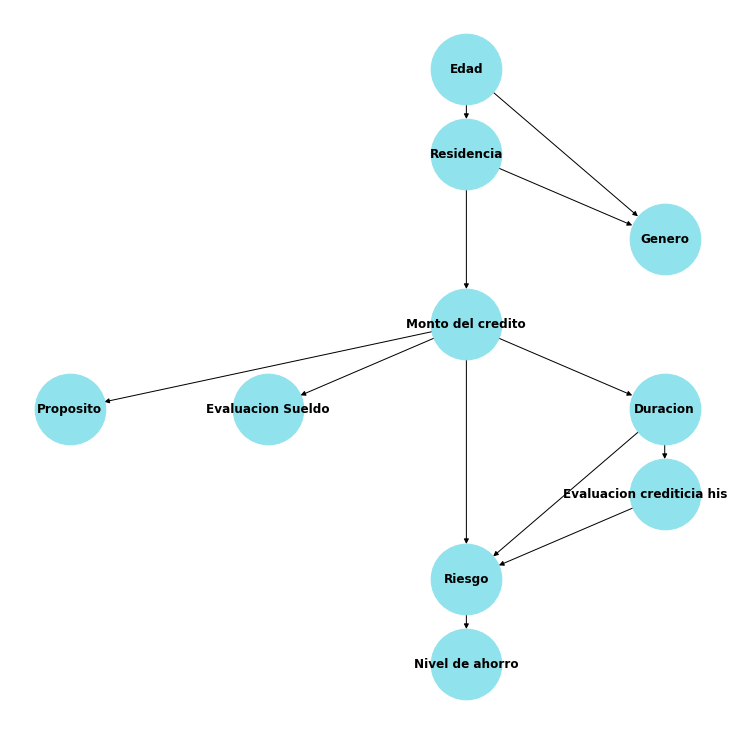

In [4]:
plt.figure(figsize=(10, 10))
# We define the appropriate positions of the structure for easy visualization (planar layout was used as an initial base)
pos = {
    "Evaluacion crediticia historica": [4, 1],
    "Edad": [3, 6],
    "Genero": [4, 4],
    "Evaluacion Sueldo": [2, 2],
    "Residencia": [3, 5],
    "Nivel de ahorro": [3, -1],
    "Monto del credito": [3, 3],
    "Duracion": [4, 2],
    "Proposito": [1, 2],
    "Riesgo": [3, 0],
}
# We draw the structure
nx.draw(
    model,
    pos,
    with_labels=True,
    font_weight="bold",
    node_size=5000,
    node_color="#90e2ec",
)
plt.show()



## 1.3 Comments, improvements and creation of the network

 **Comments:** All the connections found make sense in the context of the data, however, some directions of causality are inverted, for example, it is justifiable that the amount of the credit is related to the purpose, salary evaluation, duration and residence, however, in a real context, it is the purpose and the salary evaluation that cause the amount of the credit; the same happens with the level of savings and risk, the level of savings causes a high or low risk. Probably the most debatable connections are Age-Gender and Residence-Gender, the first could be explained by biological differences and social constructions, for example, someone of the female sex could postpone or advance some life projects due to dedicating herself to the upbringing of her children ( by this I was referring to social construction, this has been changing in recent times) which would lead to credits being concentrated in certain age ranges. In the Residence-Gender connection (it should be Gender-Residence) something similar happens, it could be happening that in marriages most of the time it is the male person who remains as the owner of the home (it has also been changing).

 Below are some assumptions from the context of the data to justify improvements.

 **Assumptions (to make the improvements):**
1.  The banking executive evaluates the level of savings of the person who requires the credit before evaluating the risk.
1.  The higher the person&#39;s salary, they can access a higher credit amount.
1.  In a married life, men are usually the owners of the residences (with current data this could be incorrect).
1.  The purpose of the project will determine the amount of the credit, each project has a required budget associated with it, for example, buying a vehicle will have a lower amount associated with it than buying a house.
1.  The banking executive is based on the historical credit evaluation to determine the duration of a credit, the better the evaluation, the more confidence there is in the person, so a higher time risk can be assumed.

 **Improvements:**
1.  The level of savings should be cause of Risk and not evidence.
1.  Salary evaluation should be causal of credit amount and not evidence.
1.  Gender should be cause of residence and not evidence.
1.  Purpose should be causal of credit amount and not evidence.
1.  Historical credit evaluation should be causal of duration and not evidence.


In [5]:
improve_model = model.copy()
# Suggested improvements are applied based on the assumptions
improve_model.remove_edge("Riesgo", "Nivel de ahorro")
improve_model.add_edge("Nivel de ahorro", "Riesgo")
improve_model.remove_edge("Monto del credito", "Evaluacion Sueldo")
improve_model.add_edge("Evaluacion Sueldo", "Monto del credito")
improve_model.remove_edge("Residencia", "Genero")
improve_model.add_edge("Genero", "Residencia")
improve_model.remove_edge("Monto del credito", "Proposito")
improve_model.add_edge("Proposito", "Monto del credito")
improve_model.remove_edge("Duracion", "Evaluacion crediticia historica")
improve_model.add_edge("Evaluacion crediticia historica", "Duracion")
improve_model.edges()


OutEdgeView([('Evaluacion crediticia historica', 'Riesgo'), ('Evaluacion crediticia historica', 'Duracion'), ('Edad', 'Residencia'), ('Edad', 'Genero'), ('Genero', 'Residencia'), ('Evaluacion Sueldo', 'Monto del credito'), ('Residencia', 'Monto del credito'), ('Nivel de ahorro', 'Riesgo'), ('Monto del credito', 'Duracion'), ('Monto del credito', 'Riesgo'), ('Duracion', 'Riesgo'), ('Proposito', 'Monto del credito')])

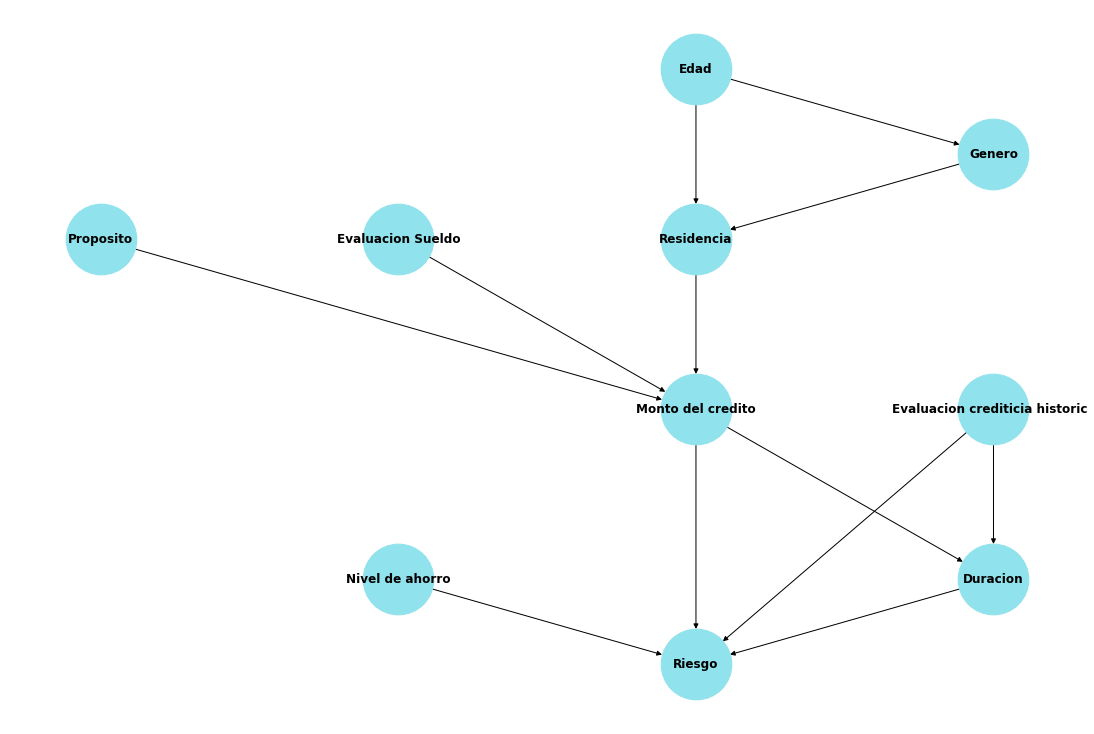

In [6]:
plt.figure(figsize=(15, 10))
# Se crea la red bayesiana en base a la estructura propuesta
bayesian_model = BayesianModel(improve_model.edges())
pos = {
    "Evaluacion crediticia historica": [4, 3],
    "Edad": [3, 7],
    "Genero": [4, 6],
    "Evaluacion Sueldo": [2, 5],
    "Residencia": [3, 5],
    "Nivel de ahorro": [2, 1],
    "Monto del credito": [3, 3],
    "Duracion": [4, 1],
    "Proposito": [1, 5],
    "Riesgo": [3, 0],
}
nx.draw(
    bayesian_model,
    pos,
    with_labels=True,
    font_weight="bold",
    node_size=5000,
    node_color="#90e2ec",
)
plt.show()



## 1.4 Parameter learning of each CPD with maximum likelihood method


In [7]:
# We fit all the CPDs of the network with the maximum likelihood estimation method from the data
bayesian_model.fit(data=data, estimator=MaximumLikelihoodEstimator)
# We check that the model has no errors
bayesian_model.check_model()


True


### Independences in Risk variable

####  Local Independences: Risk ⟂ non-descendants(Risk) | Parents(Risk)


In [8]:
# We get local independences
bayesian_model.local_independencies("Riesgo")


(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia, Proposito | Nivel de ahorro, Evaluacion crediticia historica, Monto del credito, Duracion)


#### Global Markovian Independences: Risk ⟂ Y | Z : d-sep(Risk;Y|Z), where X and Y are the rest of the variables in the credit risk assessment.


In [9]:
# Obtenemos todas las independencias globales (todas las variables)
bayesian_model.get_independencies().get_assertions()[0].get_assertion()
total = 0
for independencia in bayesian_model.get_independencies().get_assertions():
    # Imprimimos solo las independencias de la variable Riesgo
    if (next(iter(independencia.get_assertion()[0]))) == "Riesgo":
        print(independencia)
        total += 1
print(
    f"\nEl total de independencias markovianas globales de la variable Riesgo es: {total}"
)


(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia, Proposito | Monto del credito)
(Riesgo ⟂ Edad, Genero | Residencia)
(Riesgo ⟂ Proposito, Genero, Evaluacion Sueldo, Residencia | Edad, Monto del credito)
(Riesgo ⟂ Genero | Edad, Residencia)
(Riesgo ⟂ Edad, Proposito, Evaluacion Sueldo, Residencia | Monto del credito, Genero)
(Riesgo ⟂ Edad, Proposito, Genero, Residencia | Monto del credito, Evaluacion Sueldo)
(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Proposito | Monto del credito, Residencia)
(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia, Proposito | Monto del credito, Duracion)
(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia, Proposito | Monto del credito, Nivel de ahorro)
(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia, Proposito | Monto del credito, Evaluacion crediticia historica)
(Riesgo ⟂ Edad, Genero, Evaluacion Sueldo, Residencia | Proposito, Monto del credito)
(Riesgo ⟂ Edad | Genero, Residencia)
(Riesgo ⟂ Edad, Genero | Evaluacion Sueldo, Residencia)


### Queries


In [10]:
# Utilizamos el método de eliminación de variables para inferir las probabilidades solicitadas
infer = VariableElimination(bayesian_model)



#### 1) Given that we know the client&#39;s age is 21, what is the probability of high risk?


In [11]:
print(
    f'\nLa probabilidad de riesgo es: {infer.query(["Riesgo"], evidence={"Edad":"19 to 28"}).get_value(Riesgo="bad")}\n'
)


Eliminating: Proposito: 100%|███████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 105.24it/s]


La probabilidad de riesgo es: 0.3120818119920808




#### 2) Conditional probability of risk given historical credit assessment.


In [12]:
# Obtenemos todos los valores de probabilidad para riesgo alto y bajo dados los distintos posibles valores de evaluación crediticia histórica
values = np.array([])
for i in range(5):
    consulta = infer.query(["Riesgo"], evidence={"Evaluacion crediticia historica": i})
    values = np.append(values, consulta.get_value(Riesgo="bad"))
    values = np.append(values, consulta.get_value(Riesgo="good"))
values = values.reshape([5, 2])
values = values.T


Eliminating: Proposito: 100%|███████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 307.83it/s]


In [13]:
# Cargamos los valores obtenidos en un dataframe para visualizar los resultados de forma clara
prob_condicional_riesgo = pd.DataFrame(
    values,
    columns=["ECH(0)", "ECH(1)", "ECH(2)", "ECH(3)", "ECH(4)"],
    index=["Riesgo(bad)", "Riesgo(good)"],
)
prob_condicional_riesgo.head()


,ECH(0),ECH(1),ECH(2),ECH(3),ECH(4)
Riesgo(bad),0.645224,0.59626,0.326273,0.351309,0.187646
Riesgo(good),0.354776,0.40374,0.673727,0.648691,0.812354



#### 3) Given that the loan has a duration of 3 years (36 months), what is the probability of high risk?


In [14]:
print(
    f'\nLa probabilidad de riesgo es: {infer.query(["Riesgo"], evidence={"Duracion":"24 to 72"}).get_value(Riesgo="bad")}\n'
)


Eliminating: Evaluacion crediticia historica: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 235.30it/s]


La probabilidad de riesgo es: 0.5221410511675085

